# Combining dates with analysis visualization in python

Sometimes you want to do two things:

1. Plot a timeseries that handles datetimes in a clever way (e.g., with Pandas or Matplotlib)
2. Plot some kind of analysis on top of that timeseries.

Sounds simple right? It's not.

The reason for this is that plotting libraries don't *really* plot human-readable dates, they convert dates to numbers, then change the xtick labels so that they're human readable. This means that if you want to plot something *on top* of dates, it's quite confusing.

To demonstrate this, let's grab the latest stock market prices for a couple companies and
fit regression lines to them...

In [ ]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pandas_datareader.data as web
import datetime
plt.ion()

In [ ]:
start = datetime.datetime(2010, 1, 1)
end = datetime.datetime(2017, 10, 31)
companies = ['AAPL', 'IBM']
data = web.DataReader(companies, 'google', start, end)

In [ ]:
def prep_data(data):
    data = data.sort_index()
    data = data.resample('D').mean().copy()
    data = data.reset_index().dropna()
    data['High'] -= data['High'].min()
    return data

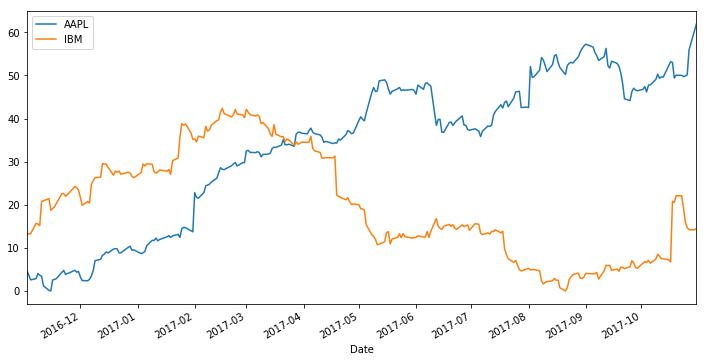

In [ ]:
fig, ax = plt.subplots(figsize=(12, 6))
for company in companies:
    this_data = prep_data(data.loc[:, :, company])
    this_data.plot.line('Date', 'High', ax=ax, label=company)

Let's say we want to fit a regression line to each stock, should be simple, right?

***ERROR:  reduction operation 'mean' not allowed for this dtype ***
***ERROR:  reduction operation 'mean' not allowed for this dtype ***


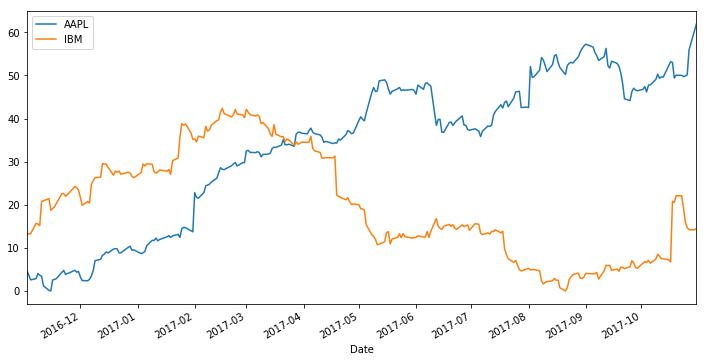

In [ ]:
fig, ax = plt.subplots(figsize=(12, 6))
for company in companies:
    this_data = prep_data(data.loc[:, :, company])
    this_data.plot.line('Date', 'High', ax=ax, label=company)
    try:
        sns.regplot('Date', 'High', data=this_data.query('Date > "2017-04-01" and Date < "2017-09-01"'))
    except Exception as ee:
        print('***ERROR: ',  ee, '***')

We got an error! That's because seaborn was treating the `Date` column as a number, when in fact it was a datetime object.

## How do we fix this?

To fix this, we need to convert the datetime labels to their ordinal (numeric) representation. There are a number of ways to convert dates to numbers. Fortunately, Matplotlib has a convenience function to convert datetime objects to their numeric representation.

In [ ]:
from matplotlib.dates import date2num
date2num(this_data['Date'][0])

736270.0

In [ ]:
# Here's how we convert the Period object to a date:
sample_ordinal = this_data['Date'].map(lambda a: date2num(a))
sample_ordinal.head()

0    736270.0
1    736271.0
2    736272.0
5    736275.0
6    736276.0
Name: Date, dtype: float64

Below we'll insert this into our plotting code to see what happens.

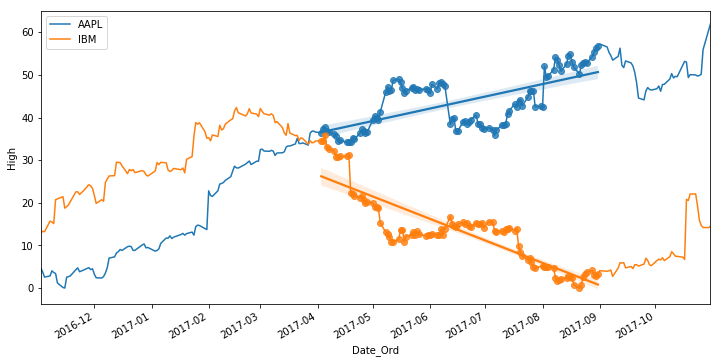

In [ ]:
fig, ax = plt.subplots(figsize=(12, 6))
for ii, company in enumerate(companies):
    this_data = prep_data(data.loc[:, :, company])
    this_data['Date_Ord'] = this_data['Date'].map(lambda a: date2num(a))
    this_data.plot.line('Date', 'High', ax=ax, label=company, color='C{}'.format(ii))
    sns.regplot('Date_Ord', 'High', data=this_data.query('Date > "2017-04-01" and Date < "2017-09-01"'),
                truncate=True, color='C{}'.format(ii))

And there you have it - mixed datetime visualization across multiple libraries.

Note that this is *not* the same thing as plotting an actual
datetime object, we're plotting a datetime *period* above, which is the only way I've figure
out how to make this work.

Of course, this is all unnecessarily complicated, and hopefully we'll see some patches
that ease this in the future. But in the meantime you can refer to the above method
for your datetime viz needs.